# Trajectory Clustering Techniques

## Introduction

This notebook contains different techniques on trajectory clustering discussed in my pattern recognition project course report and can be considered as a demonstration of the report.

The original dataset was civil flight trajectory dataset that is captured on Turkey territory. Since the dataset is large and I do not have right to publish, it was not possible to directly use the project code and observe the result. Also, the project was one of my early studies in data science field so I used some unnecessary things and the was not very clear. For these reason, I decided to apply the same methods mentioned in the paper on a publicly available dataset in a concise tutorial format.

The trajectory is defined as a set of points in n-dimensional space. As a result of this definition, speed and direction features are not considered in clustering process. For example, all of the following trajectories are considered to be the same:

 - `[[0, 0], [1, 1], [2, 2]]`
 - `[[2, 2], [1, 1], [0, 0]]`
 - `[[1, 1], [0, 0], [2, 2]]`

The notebook shows:
 - How to represent trajectory data
 - Haussdorf distance to calculate pairwise distance
 - Applying trajectory segmentation to reduce the number of points for better runtime performance.
 - K-medoid clustering
 - DBSCAN clustering
 - How to plot clustered trajectories

## How to run

Use python 3.6+.

The following libraries are needed to be able to run all code cells without any errors. Please refer to their webpages for installation details.

 - scipy (For fast hausdorff distance implementation)
 - matplotlib and seaborn (For visualizations)
 - scikit-learn (For DBSCAN clustering model)

In [12]:
# 0 - Import related libraries

import urllib
import zipfile
import os
import scipy.io
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN

from kmedoid import kMedoids # kMedoids code is adapted from https://github.com/letiantian/kmedoids

# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

In [3]:
# Utility Functions

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    plt.show()

## Dataset

The dataset is obtained from http://cvrr.ucsd.edu/bmorris/datasets/dataset_trajectory_clustering.html.

After downloading, unzipping, importing and preprocessing each trajectory should be a numpy array in `(N, 2)` shape. Each row represents a point in 2 dimensional space. I thingk by little tweaking, code can handle d-dimensional data.

B. T. Morris and M. M. Trivedi, "Learning Trajectory Patterns by Clustering: Experimental
Studies and Comparative Evaluation," in Proc. IEEE Inter. Conf. on Computer Vision and Pattern Recog.,
Maimi, Florida, June. 2009 [pdf](http://cvrr.ucsd.edu/bmorris/docs/morris_cvpr2009.pdf)

In [4]:
# 1 - Get and prepare dataset

dataset_link = 'http://cvrr.ucsd.edu/LISA/Datasets/TrajectoryClustering/CVRR_dataset_trajectory_clustering.zip'
data_folder = 'data'
filename = '%s/cross.mat' % data_folder

# Download the dataset
is_download_required = not os.path.exists(data_folder)

if is_download_required:
    zip_filename = 'data.zip'
    urllib.request.urlretrieve(dataset_link, zip_filename)
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(data_folder)
    zip_ref.close()

# Import dataset
traj_data = scipy.io.loadmat(filename)['tracks']

traj_lst = []
for data_instance in traj_data:
    traj_lst.append(np.vstack(data_instance[0]).T)

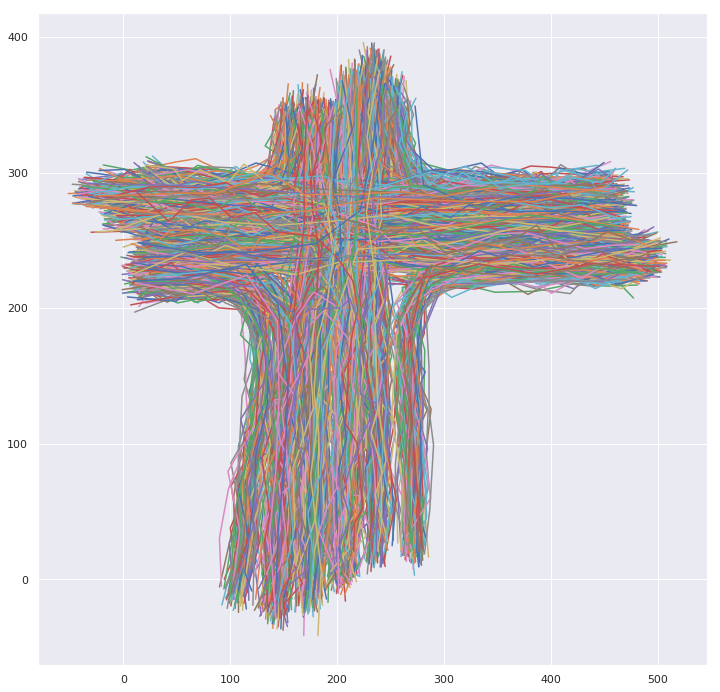

In [5]:
# Plotting

for traj in traj_lst:
    plt.plot(traj[:, 0], traj[:, 1])

## Trajectory Segmentation

Calculating distance between trajectories with large number of points can be tricky because of runtime limitations. To overcome this problem, we decided to remove *uninteresting* points from trajectories. To clarify which points are interesting and which are not, we consider a point as a corner point or interesting point if trajectory changes its direction at that point. By storing corner points only, we can reduce the number of points in a trajectory the and therefore we can achieve better runtime performances.

![Trajectory Segmentation](https://raw.githubusercontent.com/Shathra/comparing-trajectory-clustering-methods/master/segmentation.png)

Left shows the original trajectory, right shows the segmented trajectory having smaller set of points.

In [6]:
# 2 - Trajectory segmentation

degree_threshold = 5

for traj_index, traj in enumerate(traj_lst):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst[traj_index] = traj[hold_index_lst, :]

There are many distance functions for trajectories. Here, I use hausdorff distance. For more information: https://en.wikipedia.org/wiki/Hausdorff_distance

Instead of calculating distances, we calculate distance values once and store them in matrix `D`. Since each pair of distances should be calculated and stored, this part of code has O(N^2) time and memory complexity. In the paper, I used sparse matrices to solve the memory issue.

In [7]:
# 3 - Distance matrix

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst[i], traj_lst[j])
        D[i, j] = distance
        D[j, i] = distance

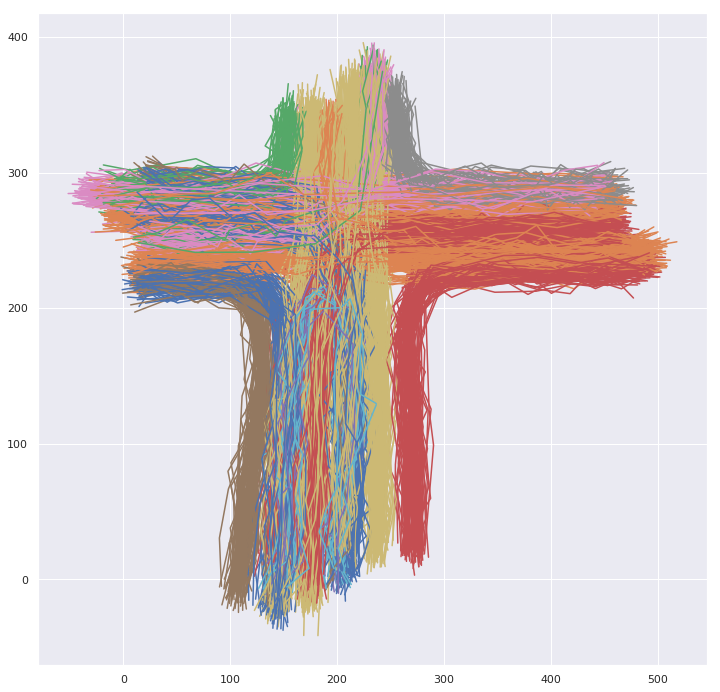

In [11]:
# 4 - Different clustering methods

# 4.1 - kmedoids

k = 10 # The number of clusters
medoid_center_lst, cluster2index_lst = kMedoids(D, k)

cluster_lst = np.empty((traj_count,), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst[cluster2index_lst[cluster]] = cluster
    
plot_cluster(traj_lst, cluster_lst)

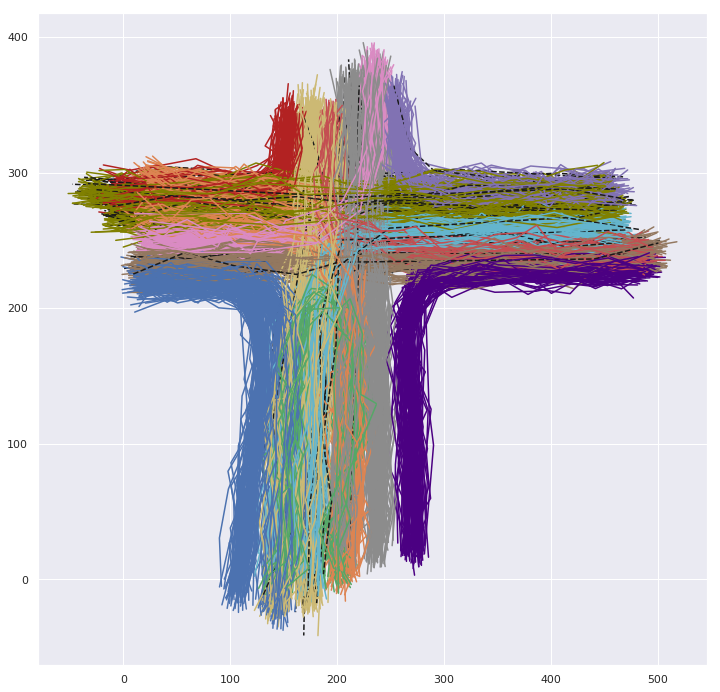

In [9]:
# 4.2 - dbscan

mdl = DBSCAN(eps=400, min_samples=10)
cluster_lst = mdl.fit_predict(D)

plot_cluster(traj_lst, cluster_lst)